In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
def read_text(filename):
  file = open(filename, mode='rt', encoding='utf-8')
  text = file.read()
  file.close()
  return text

In [ ]:
def to_line(text):
  sentences = text.strip().split('\n')
  sentences = [i.split('\t') for i in sentences]
  return sentences

In [ ]:
data = read_text("/content/deu.txt")
ger_eng = to_line(data)

In [ ]:
ger_eng = array(ger_eng)
ger_eng = ger_eng[:50000,:]
ger_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Thank you for coming.', 'Danke fürs Kommen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #64536 (CK) & #1317354 (Pfirsichbaeumchen)'],
       ['Thank you for coming.', 'Danke, dass du gekommen bist!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #64536 (CK) & #1823152 (Pfirsichbaeumchen)'],
       ['Thank you for coming.', 'Danke, dass Sie gekommen sind!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #64536 (CK) & #1823153 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [ ]:
eng_lang = []
ger_lang = []

#sentence lengths
for i in ger_eng[:, 0]:
  eng_lang.append(len(i.split()))
for i in ger_eng[:, 1]:
  ger_lang.append(len(i.split()))

length_df = pd.DataFrame({'English': eng_lang, 'German': ger_lang}) 

In [ ]:
print(eng_lang)
print(ger_lang)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 

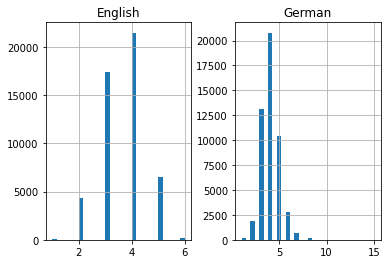

In [ ]:
length_df.hist(bins=30)
plt.show()

In [ ]:
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
#English Tokenizer
eng_tokenizer = tokenization(ger_eng[:, 0])
# print(eng_tokenizer)
english_vocab_size = len(eng_tokenizer.word_index)+1
eng_length = 8
print("English vocabulary size: ", english_vocab_size)

English vocabulary size:  6091


In [ ]:
#German Tokenizer
ger_tokenizer = tokenization(ger_eng[:, 1])
print(ger_tokenizer)
german_vocab_size = len(ger_tokenizer.word_index)+1
ger_length = 8
print("German vocabulary size: ", german_vocab_size)

German vocabulary size:  10033


In [ ]:
def encode_sequence(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(seq, maxlen = length, padding='post')
  return seq

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ger_eng, test_size=0.2, random_state=12)

In [ ]:
trainX = encode_sequence(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequence(eng_tokenizer, eng_length, train[:, 0])
print(len(trainX))
print(len(trainY))

40000
40000


In [ ]:
testX = encode_sequence(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequence(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
print(len(testX))
print(len(testY))

10000
10000


In [ ]:
#build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [ ]:
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
model = build_model(german_vocab_size, english_vocab_size, ger_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = "model.a1.12_aditya"
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=3, batch_size=512,
                    validation_split=0.1,
                    callbacks=[checkpoint], verbose=1)

Epoch 1/3
71/71 [==============================] - ETA: 0s - loss: 3.2572
Epoch 1: val_loss improved from inf to 2.74407, saving model to model.a1.12_aditya


71/71 [==============================] - 310s 4s/step - loss: 3.2572 - val_loss: 2.7441
Epoch 2/3
71/71 [==============================] - ETA: 0s - loss: 2.6662
Epoch 2: val_loss improved from 2.74407 to 2.60306, saving model to model.a1.12_aditya


71/71 [==============================] - 300s 4s/step - loss: 2.6662 - val_loss: 2.6031
Epoch 3/3
71/71 [==============================] - ETA: 0s - loss: 2.4586
Epoch 3: val_loss improved from 2.60306 to 2.42329, saving model to model.a1.12_aditya


71/71 [==============================] - 298s 4s/step - loss: 2.4586 - val_loss: 2.4233


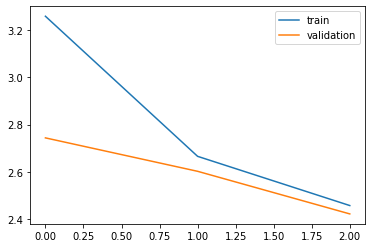

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
model = load_model('model.a1.12_aditya')
preds = model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

313/313 [==============================] - 38s 116ms/step


In [ ]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if (index == n).all():
      return word
  return None

In [ ]:
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j>0:
      if(t==get_word(i[j-1], eng_tokenizer)) or (t==None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t==None):
        temp.append('')
      else:
        temp.append(t)
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual': test[:,0], 'predicted': preds_text})

10000
80000


In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,Tom can't remember.,
1,I hate my roommate.,
2,The dog bit my hand.,
3,This is Tom's room.,
4,I eat less than you.,
5,How are you today?,
6,Let Tom go.,
7,Tom is after you.,
8,I hit on a good idea.,
9,Tom bit me.,


In [ ]:
pred_df.tail(15)

,actual,predicted
4985,Do you trust anyone?,
4986,That's great!,
4987,It was on sale.,
4988,Can you whistle?,
4989,That's ridiculous.,
4990,It is pitch dark.,
4991,Prices will go up.,
4992,She is angry with me.,
4993,It's poison.,
4994,Go with these men.,
